XGBoost Accuracy: 0.9269 
────────────────────────

 Classification Report:
              precision    recall  f1-score   support

           A       0.93      0.62      0.74        21
           B       0.88      0.85      0.87        54
           C       0.95      0.91      0.93        78
           D       0.90      0.88      0.89        83
           F       0.94      0.99      0.96       243

    accuracy                           0.93       479
   macro avg       0.92      0.85      0.88       479
weighted avg       0.93      0.93      0.92       479



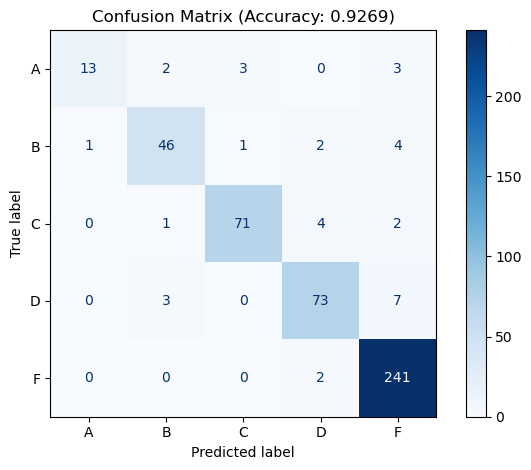

First 20 Predictions:


,StudentID,GradeClass,Predicted,ActualGrade,PredictedGrade,Match
0,2594,4.000000,4,F,F,True
1,2832,4.000000,4,F,F,True
2,2568,4.000000,4,F,F,True
3,2203,4.000000,4,F,F,True
4,1674,4.000000,4,F,F,True
5,1577,4.000000,4,F,F,True
6,2484,4.000000,4,F,F,True
7,1297,1.000000,1,B,B,True
8,2320,4.000000,4,F,F,True
9,2026,4.000000,4,F,F,True


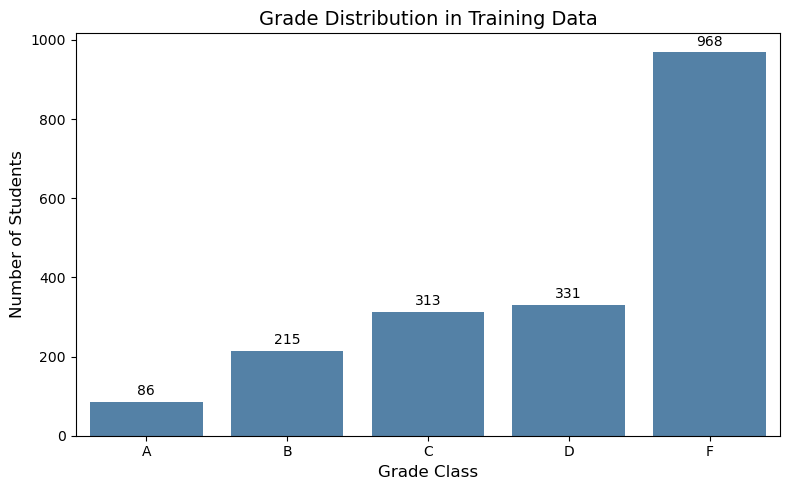

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
from xgboost import XGBClassifier
import pickle
import os
import warnings

# === Load your data ===
train_data = pd.read_csv("train_data.csv")
test_data = pd.read_csv("test_data.csv")

# === Separate features and labels ===
X_train = train_data.drop(columns=["GradeClass", "StudentID"])
y_train = train_data["GradeClass"].astype(int)

X_test = test_data.drop(columns=["GradeClass", "StudentID"])
y_test = test_data["GradeClass"].astype(int)

# === Scale your data (optional for XGBoost, but kept for consistency) ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === Train XGBoost Model ===
model = XGBClassifier(n_estimators=100, eval_metric='mlogloss', random_state=42)
model.fit(X_train_scaled, y_train)

# === Make predictions ===
y_pred = model.predict(X_test_scaled)

# === Grade mapping ===
grade_map = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'F'}
y_test_letters = pd.Series(y_test).map(grade_map)
y_pred_letters = pd.Series(y_pred).map(grade_map)
label_names = [grade_map[i] for i in sorted(grade_map)]

# === Evaluation ===
accuracy = accuracy_score(y_test_letters, y_pred_letters)
print("XGBoost Accuracy:", round(accuracy, 4) , "\n────────────────────────")
print("\n Classification Report:")
print(classification_report(y_test_letters, y_pred_letters, target_names=label_names, zero_division=0))

# === Confusion Matrix ===
ConfusionMatrixDisplay.from_estimator(
    model,
    X_test_scaled,
    y_test,
    display_labels=label_names,
    cmap='Blues'
)
plt.title(f"Confusion Matrix (Accuracy: {round(accuracy, 4)})")
plt.tight_layout()
plt.show()

# === Save model and scaler ===
os.makedirs("project testing", exist_ok=True)
with open("project testing/xgboost_model.pkl", "wb") as f:
    pickle.dump(model, f)
with open("project testing/xgboost_scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

# === Prediction comparison table ===
comparison_df = test_data[["StudentID", "GradeClass"]].copy()
comparison_df["Predicted"] = y_pred
comparison_df["ActualGrade"] = comparison_df["GradeClass"].astype(int).map(grade_map)
comparison_df["PredictedGrade"] = pd.Series(y_pred).astype(int).map(grade_map)
comparison_df["Match"] = comparison_df["ActualGrade"] == comparison_df["PredictedGrade"]
comparison_df = comparison_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Save prediction table
comparison_df.to_csv("project testing/prediction_results_xgboost.csv", index=False)

# === Display sample ==
try:
    from IPython.display import display

    def highlight_false_text(row):
        styles = []
        for col in row.index:
            if col == "Match" and row["Match"] == False:
                styles.append("color: red; background-color: black")
            else:
                styles.append("background-color: black; color: white")
        return styles

    print("First 20 Predictions:")
    display(comparison_df.head(20).style.apply(highlight_false_text, axis=1))
except:
    print("\nFirst 20 Predictions:")
    print(comparison_df.head(20).to_string(index=False))

# === Final Grade Distribution Plot ===
plt.figure(figsize=(8, 5))
grade_counts = train_data["GradeClass"].astype(int).value_counts().sort_index()
grade_labels = ['A', 'B', 'C', 'D', 'F']
sns.barplot(x=grade_labels, y=grade_counts.values, color='steelblue')
for i, count in enumerate(grade_counts.values):
    plt.text(i, count + 10, str(count), ha='center', va='bottom', fontsize=10)
plt.title("Grade Distribution in Training Data", fontsize=14)
plt.xlabel("Grade Class", fontsize=12)
plt.ylabel("Number of Students", fontsize=12)
plt.tight_layout()
plt.show()
